# Оценивание плотностей. Непараметрическая регрессия

## Задача 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import seaborn as sns
import statsmodels.api as sm
%config InlineBackend.figure_format = 'svg' 
from pylab import rcParams
rcParams['figure.figsize'] = 10,5

%matplotlib inline

In [2]:
df = pd.read_csv('glass.dat', sep='\s+')
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,type
1,3.01,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,WinF
2,-0.39,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,WinF
3,-1.82,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,WinF
4,-0.34,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,WinF
5,-0.58,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,WinF


Выберем оптимальную ширину окна пропускания. Для этого посмотрим на гистограмму и графики для разной ширины.

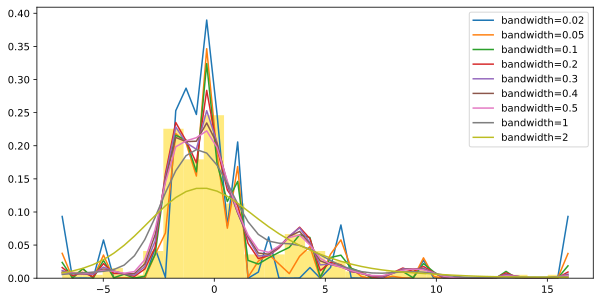

In [3]:
y = df['RI']
kernel_density = sm.nonparametric.KDEUnivariate(y)
xx = np.linspace(min(y), max(y))
hs = [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2]
plt.figure(figsize=(10, 5))
plt.hist(y, bins=25, density=True, color="gold", alpha=0.5)
for h in hs:
    kernel_density.fit(bw=h, kernel="gau")
    plt.plot(xx, kernel_density.evaluate(xx), label="bandwidth={}".format(h))
plt.legend()
plt.show()

Наиболее подходящим кажется bandwidth = 0.3.

Вспомним теорему о ядерной оценке плотности:
$$\hat{p_n}(z) = p_{Z_n}(z) + \frac{\xi_n(z)}{\sqrt{n h_n}},$$
где $\xi_n(z) \rightarrow \xi(z) ~ N(0, \alpha p(z)),$
$\alpha = 1$ для гауссовского ядра.

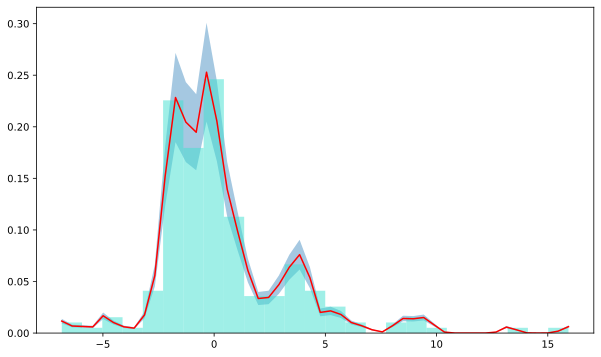

In [4]:
kernel_density.fit(bw=0.3, kernel="gau")
kde = kernel_density.evaluate(xx)
inter = sps.norm.interval(0.95, loc=0, scale=kde) / (np.sqrt(y.shape[0] * 0.5))
plt.figure(figsize=(10, 6))
plt.hist(y, bins=25, density=True, color="turquoise", alpha=0.5)
plt.plot(xx, kde, color="r")
plt.fill_between(xx, inter[0] + kde, kde + inter[1], alpha=0.4)
plt.show()

## Задача 3

In [5]:
df = pd.read_csv('hw10t3.csv')
df.head()

,Unnamed: 0,y,x
0,0,0.064771,0.180249
1,1,-0.683449,-0.811201
2,2,0.501485,-0.616333
3,3,0.263588,-0.749556
4,4,-0.323165,-0.414561


In [6]:
x = np.array(df['x'].values)
y = np.array(df['y'].values)

Для начала напишем класс для вычисления оценки Надарая-Ватсона.

In [7]:
%run kernel_regr.py

<Figure size 432x288 with 0 Axes>

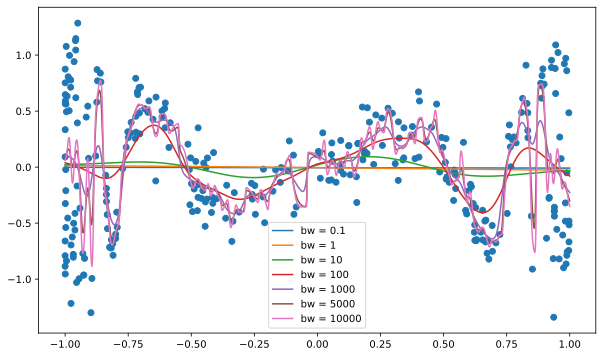

In [8]:
xx = np.linspace(-1, 1, 1000)
gammas = [0.1, 1, 10, 100, 1000, 5000, 10000]
plt.figure(figsize=(10, 6))
plt.scatter(x, y)
for g in gammas:
    kr = KernelRegression(gamma=g)
    kr.fit(x[:, np.newaxis], y)
    plt.plot(xx, kr.predict(xx[:, np.newaxis]), label="bw = {}".format(g))
plt.legend()
plt.show()

Видим, что оптимальный параметр bandwidth $\approx 1000$.

Теперь построим непараметрическую регрессию методом сглаживающего сплайна.

In [9]:
from scipy.interpolate import UnivariateSpline

Сначала посмотрим на кубический сплайн.

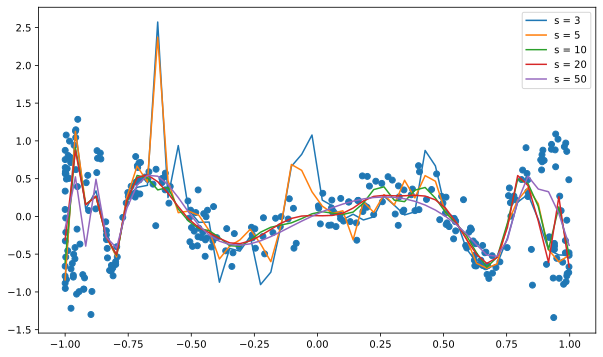

In [10]:
plt.figure(figsize=(10, 6))
sort_ind = np.argsort(x)
x_sort = x[sort_ind]
y_sort = y[sort_ind]
xx = np.linspace(min(x_sort), max(x_sort))
plt.scatter(x_sort, y_sort)
for s in [3, 5, 10, 20, 50]:
    spline = UnivariateSpline(x_sort, y_sort, s=s)
    plt.plot(xx, spline(xx), label="s = {}".format(s))
plt.legend()
plt.show()

Наверное, оптимальным является сглаживающий фактор, равный 20.

Теперь посмотрим на сплайн степени 2.

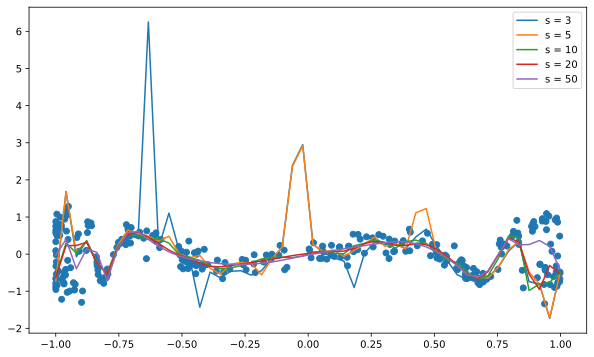

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(x_sort, y_sort)
for s in [3, 5, 10, 20, 50]:
    spline = UnivariateSpline(x_sort, y_sort, s=s, k=2)
    plt.plot(xx, spline(xx), label="s = {}".format(s))
plt.legend()
plt.show()

Здесь также оптимальным является $s \approx 20$. При маленьких значениях s сплайн в обоих случаях слишком сильно подстраивается под выборку.

Сравним два использованных метода.

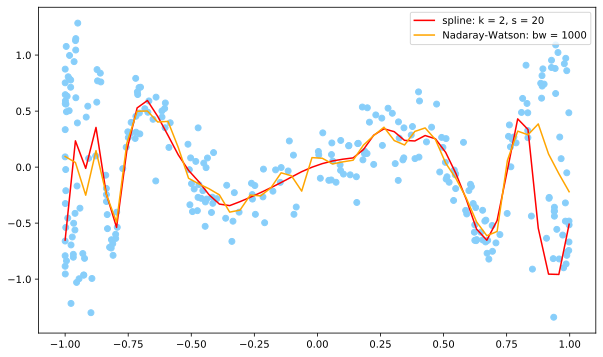

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(x_sort, y_sort, color="lightskyblue")
spline = UnivariateSpline(x_sort, y_sort, s=15, k=2)
plt.plot(xx, spline(xx), color="r", label="spline: k = 2, s = 20")
kr = KernelRegression(gamma=1000)
kr.fit(x[:, np.newaxis], y)
plt.plot(xx, kr.predict(xx[:, np.newaxis]), color="orange", label="Nadaray-Watson: bw = 1000")
plt.legend()
plt.show()

В данном случае оба метода оказались довольно близки, но сплайн более гладкий в середине выборки и сильнее подстраивается под выборку на краях, с оценкой Надарая-Ватсона ситуация противоположная. Однако это выполняется для определённых параметров, в общем случае оценка Надарая-Ватсона выглядит более гладкой (на предыдущих графиках). 

Интеграл от квадрата второй производной прибавляем для того, чтобы интерполяция была более гладкой, это своего рода регуляризация.

## Задача 4

In [13]:
df = pd.read_csv('hw10t4.csv')
df.head()

,Unnamed: 0,Andrew,Bernard,Carle,Davide,Eugene,Fred,George,Marmaduke
0,0,-36.944209,7.115482,3.076607,1.832458,2.059673,0.112941,-0.706182,5.409550
1,1,-76.268155,9.871361,1.854843,1.628231,2.818672,0.061049,-0.595321,4.869631
2,2,-45.020962,7.772921,1.019105,1.595419,-0.906164,0.236599,-1.759698,3.493061
3,3,-31.935210,6.670168,2.117598,-1.274111,1.835605,0.270813,1.996759,4.904334
4,4,-40.738145,7.432577,0.048449,-0.865901,2.321549,0.086520,1.720531,3.247345


In [14]:
X = df.drop('Marmaduke', axis=1).values
y = df['Marmaduke'].values

Воспользуемся линейной регрессией с регуляризациями Lasso и Ridge.

In [15]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [16]:
def model_score(model, kfold, X, y):
    score = []
    for train_ind, test_ind in kfold.split(X):
        X_train, X_test = X[train_ind], X[test_ind]
        y_train, y_test = y[train_ind], y[test_ind]
        model.fit(X_train, y_train)
        y_preds = model.predict(X_test)
        score.append(mean_squared_error(y_test, y_preds))
    return np.sqrt(np.mean(score))

In [17]:
kfold = KFold(n_splits=3, random_state=42, shuffle=True)

In [18]:
lrl = Lasso()
print(model_score(lrl, kfold, X, y))

1.611395677756022


In [19]:
lrr = Ridge()
print(model_score(lrr, kfold, X, y))

1.314881558284629


Теперь проделаем то же самое для оценки Надарая-Ватсона.

In [20]:
kf = KernelRegression(gamma=0.001)
print(model_score(kf, kfold, X, y))

1.8061869486874493


Видим, что результаты для линейной регрессии лучше, чем для оценки Надарая-Ватсона.

Реализовать алгоритм настройки с возвращением, к сожалению, не успеваю :(